### Import Librabries

In [30]:
# import required package for data handling
import pandas as pd
import numpy as np

# import required packages for splitting data
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# import required packages for evaluating models
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# import `logistic regression` model
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt

### Load the source data

In [31]:
# Create dataframe and fill missing values
df = pd.read_csv('Competition1_raw_data.csv', header=0, na_values=['-'])
df.head(5)
df.dtypes

I1          object
I2          object
I3          object
P(IPO)     float64
P(H)       float64
P(L)       float64
P(1Day)    float64
C1         float64
C2         float64
C3         float64
C4         float64
C5         float64
C6         float64
C7         float64
T1         float64
T2         float64
T3         float64
T4         float64
T5         float64
S1         float64
S2         float64
S3         float64
dtype: object

### Analyze the Source Data

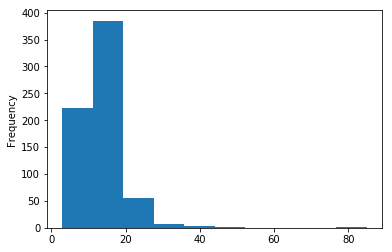

In [32]:
df['P(IPO)'].plot.hist()

### Data Cleaning

In [33]:
# Calculating the number of nulls in each column.
# df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 22 columns):
I1         682 non-null object
I2         682 non-null object
I3         674 non-null object
P(IPO)     677 non-null float64
P(H)       672 non-null float64
P(L)       672 non-null float64
P(1Day)    660 non-null float64
C1         660 non-null float64
C2         660 non-null float64
C3         646 non-null float64
C4         660 non-null float64
C5         676 non-null float64
C6         676 non-null float64
C7         610 non-null float64
T1         681 non-null float64
T2         681 non-null float64
T3         681 non-null float64
T4         681 non-null float64
T5         681 non-null float64
S1         681 non-null float64
S2         681 non-null float64
S3         681 non-null float64
dtypes: float64(19), object(3)
memory usage: 117.3+ KB


In [34]:
# Add Positive EPS dummy column C3_D with dummy variable set to 1 if C3 is positive, otherwise 0. 
df['C3_D'] = pd.get_dummies(df.C3 > 0, drop_first=True, dtype=bool)

# Add Share Overhang column C5_D.
df['C5_D']=df['C5']/df['C6']

# Add Up Revision column C6_D.
df['P(mid)'] = ((df['P(H)']+df['P(L)'])/2)
df['C6_D'] = ((df['P(IPO)']-df['P(mid)'])/df['P(mid)']*0.01).where((df['P(IPO)'] > df['P(mid)']), 0)

In [35]:
# Create column T1_D with Percent of long sentences
df['T1_D']=df['T4']/df['T1']
# Create column T3_D with Percent of real words
df['T3_D']=df['T3']/df['T2']
# Create column T5_D with Percent of long words
df['T5_D']=df['T5']/df['T2']
# Create column S1_D with Percent of Positive words
df['S1_D']=df['S1']/df['T2']
# Create column S2_D with Percent of real words
df['S2_D']=df['S2']/df['T2']
# Create column S3_D with Percent of real words
df['S3_D']=df['S3']/df['T2']

##### Adding Target Variables

In [36]:
# Add Pre-IPO Price Revision column Y1.
df['Y1'] = np.where(df['P(IPO)'] < ((df['P(H)'] + df['P(L)'])/2), '1', '0')
df['Y1'] = df['Y1'].astype('int')

#Add Post-IPO Initial Return column Y2.
df['Y2'] = np.where(df['P(IPO)'] < df['P(1Day)'], '1', '0')
df['Y2'] = df['Y2'].astype('int')

#df.info()
#df.head(5)

In [37]:
# Change the data types 
df['Y1'] = df['Y1'].astype('bool')
df['Y2'] = df['Y2'].astype('bool')
df['C2'] = df['C2'].astype('bool')
#df.info()

In [38]:
# Drop columns and view head
df.drop(['P(IPO)', 'P(H)', 'P(L)', 'P(1Day)', 'P(mid)', 'C3', 'C5', 'C6', 'T1', 'T2', 'T3', 'T4', 'T5', 'S1', 'S2', 'S3'], axis=1, inplace=True)
df.head()

I1                                  I2    I3     C1     C2        C4  \
0  AATI  ADVANCED ANALOGIC TECHNOLOGIES INC  3674  122.0   True  0.029074   
1  ABPI     ACCENTIA BIOPHARMACEUTICALS INC  2834  259.0  False -0.013352   
2  ACAD          ACADIA PHARMACEUTICALS INC  2834   90.0   True  0.020715   
3  ACHN       ACHILLION PHARMACEUTICALS INC  2834  209.0   True  0.020023   
4  ACLI     AMERICAN COMMERCIAL LINES INC.   4492   80.0   True -0.034895   

        C7   C3_D       C5_D      C6_D      T1_D      T3_D      T5_D  \
0   51.345   True   3.864345  0.001111  0.640426  0.908876  0.054250   
1   25.936  False  12.028832  0.000000  0.644753  0.898724  0.051395   
2    7.378  False   3.369134  0.000000  0.636816  0.909350  0.061764   
3    8.526  False   3.299697  0.000000  0.539634  0.917060  0.061630   
4  632.298   True   3.726269  0.000500  0.587413  0.888469  0.048550   

       S1_D      S2_D      S3_D     Y1     Y2  
0  0.004875  0.009199  0.010929  False   True  
1  0.003258  0.011105  0.010876   True  False  
2  0.011593  0.006271  0.011403   True  False  
3  0.009686  0.007144  0.013319   True   True  
4  0.004518  0.010047  0.011261  False   True

Check the shape of the data.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 18 columns):
I1      682 non-null object
I2      682 non-null object
I3      674 non-null object
C1      660 non-null float64
C2      682 non-null bool
C4      660 non-null float64
C7      610 non-null float64
C3_D    682 non-null bool
C5_D    676 non-null float64
C6_D    682 non-null float64
T1_D    681 non-null float64
T3_D    679 non-null float64
T5_D    679 non-null float64
S1_D    679 non-null float64
S2_D    679 non-null float64
S3_D    679 non-null float64
Y1      682 non-null bool
Y2      682 non-null bool
dtypes: bool(4), float64(11), object(3)
memory usage: 77.3+ KB


#### Imputation

In [40]:
pd.options.mode.use_inf_as_na = True

In [41]:
# Replace the missing data with mean/median/mode
#df[df.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]

df['C1'].fillna(df['C1'].median(), inplace = True)
df['I3'].fillna(df['I3'].mode(), inplace = True)
df['C2'].fillna(df['C2'].median(), inplace = True)
df['C4'].fillna(df['C4'].median(), inplace = True)
df['C7'].fillna(df['C7'].median(), inplace = True)
df['C5_D'].fillna(df['C5_D'].median(), inplace = True)
df['T1_D'].fillna(df['T1_D'].median(), inplace = True)
df['T3_D'].fillna(df['T3_D'].median(), inplace = True)
df['T5_D'].fillna(df['T5_D'].median(), inplace = True)
df['S1_D'].fillna(df['S1_D'].median(), inplace = True)
df['S2_D'].fillna(df['S2_D'].median(), inplace = True)
df['S3_D'].fillna(df['S3_D'].median(), inplace = True)
df.isnull().sum()
print(df.describe(include= 'float64'))

                C1          C4            C7        C5_D        C6_D  \
count   682.000000  682.000000    682.000000  682.000000  682.000000   
mean    148.350440    0.007342    458.587321    4.625759    0.000523   
std     150.518513    0.032777   1563.531760    6.245823    0.001074   
min      10.000000   -0.162352      0.074000    0.283223    0.000000   
25%      85.000000   -0.013352     41.511500    2.853439    0.000000   
50%     107.000000    0.009125    103.833000    3.753607    0.000000   
75%     152.750000    0.030941    289.758000    4.865080    0.000714   
max    2087.000000    0.092896  30683.000000   99.787255    0.010000   

             T1_D        T3_D        T5_D        S1_D        S2_D        S3_D  
count  682.000000  682.000000  682.000000  682.000000  682.000000  682.000000  
mean     0.628062    0.913839    0.080496    0.005488    0.009151    0.011833  
std      0.083532    0.626453    0.744773    0.004787    0.004299    0.008962  
min      0.000000    0.000000  

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 18 columns):
I1      682 non-null object
I2      682 non-null object
I3      674 non-null object
C1      682 non-null float64
C2      682 non-null bool
C4      682 non-null float64
C7      682 non-null float64
C3_D    682 non-null bool
C5_D    682 non-null float64
C6_D    682 non-null float64
T1_D    682 non-null float64
T3_D    682 non-null float64
T5_D    682 non-null float64
S1_D    682 non-null float64
S2_D    682 non-null float64
S3_D    682 non-null float64
Y1      682 non-null bool
Y2      682 non-null bool
dtypes: bool(4), float64(11), object(3)
memory usage: 77.3+ KB


In [43]:
df['I3']=df['I3'].fillna(' ')
df_I3 = df.I3
df_I3.head()
#df_I3 = df_I3.astype('str')
# check the value in column contains ',', if so then replace the whole value as '0'
df_I3[df.I3.str.contains(",")] = '0'
df_I3[df.I3.str.contains(" ")] = '0'
# You should change the dtype back to 'float' or 'int' to match the original data
# if the original dtype is object then do NOT do this!!!
#df_I3 = df_I3.astype('float')
# look at the first 5 values to see if they are changed
df_I3.head(12)

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0     3674
1     2834
2     2834
3     2834
4     4492
5     7379
6     2836
7     2834
8     7372
9     3714
10       0
11    2854
Name: I3, dtype: object

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 18 columns):
I1      682 non-null object
I2      682 non-null object
I3      682 non-null object
C1      682 non-null float64
C2      682 non-null bool
C4      682 non-null float64
C7      682 non-null float64
C3_D    682 non-null bool
C5_D    682 non-null float64
C6_D    682 non-null float64
T1_D    682 non-null float64
T3_D    682 non-null float64
T5_D    682 non-null float64
S1_D    682 non-null float64
S2_D    682 non-null float64
S3_D    682 non-null float64
Y1      682 non-null bool
Y2      682 non-null bool
dtypes: bool(4), float64(11), object(3)
memory usage: 77.3+ KB


#### Normalization

In [45]:
#review all columns to later identify needed ones for normalization based on data dictionary and data type
print(df.columns)
cols= df.columns

Index(['I1', 'I2', 'I3', 'C1', 'C2', 'C4', 'C7', 'C3_D', 'C5_D', 'C6_D',
       'T1_D', 'T3_D', 'T5_D', 'S1_D', 'S2_D', 'S3_D', 'Y1', 'Y2'],
      dtype='object')


In [46]:
# checking the continuous columns/float64 that needs to be normalized 
print(df.describe(include= 'float64'))

# Creating new variable (cf) for continuous datatype
cf= df.select_dtypes(include=['float64'])

                C1          C4            C7        C5_D        C6_D  \
count   682.000000  682.000000    682.000000  682.000000  682.000000   
mean    148.350440    0.007342    458.587321    4.625759    0.000523   
std     150.518513    0.032777   1563.531760    6.245823    0.001074   
min      10.000000   -0.162352      0.074000    0.283223    0.000000   
25%      85.000000   -0.013352     41.511500    2.853439    0.000000   
50%     107.000000    0.009125    103.833000    3.753607    0.000000   
75%     152.750000    0.030941    289.758000    4.865080    0.000714   
max    2087.000000    0.092896  30683.000000   99.787255    0.010000   

             T1_D        T3_D        T5_D        S1_D        S2_D        S3_D  
count  682.000000  682.000000  682.000000  682.000000  682.000000  682.000000  
mean     0.628062    0.913839    0.080496    0.005488    0.009151    0.011833  
std      0.083532    0.626453    0.744773    0.004787    0.004299    0.008962  
min      0.000000    0.000000  

In [47]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

#x = cf.values #returns a numpy array
scaler= MinMaxScaler()
scaler.fit_transform(cf)

array([[5.39239287e-02, 7.49962414e-01, 1.67099448e-03, ...,
        4.08729848e-02, 7.92361573e-02, 2.54230680e-02],
       [1.19884449e-01, 5.83747768e-01, 8.42879196e-04, ...,
        2.75721222e-02, 1.00670704e-01, 2.51909695e-02],
       [3.85170920e-02, 7.17212778e-01, 2.38047701e-04, ...,
        9.61488459e-02, 4.63171845e-02, 2.74994403e-02],
       ...,
       [4.91092922e-02, 7.55255452e-01, 1.80416301e-03, ...,
        3.52484773e-02, 7.74926209e-02, 2.10316883e-02],
       [3.27395282e-02, 7.62538533e-01, 3.83871473e-03, ...,
        5.64929057e-02, 3.60905122e-02, 3.93617857e-02],
       [1.30476649e-01, 7.32775505e-01, 4.78930856e-02, ...,
        6.70971325e-02, 7.51293248e-02, 3.69096935e-02]])

#### Standardization

In [60]:
#Standardization
import scipy
scipy.stats.zscore(cf, axis=0, ddof=0)

array([[-0.17519293,  0.66353865, -0.26065426, ..., -0.12825638,
         0.01104092, -0.10095086],
       [ 0.73566214, -0.63180489, -0.27691722, ..., -0.4661801 ,
         0.45473085, -0.10686693],
       [-0.3879474 ,  0.40831427, -0.28879521, ...,  1.27609051,
        -0.67037386, -0.04802519],
       ...,
       [-0.2416787 ,  0.70478834, -0.25803903, ..., -0.27115346,
        -0.02504986, -0.21288489],
       [-0.46773033,  0.76154682, -0.21808345, ...,  0.2685857 ,
        -0.88206351,  0.25433995],
       [ 0.88193083,  0.52959767,  0.64707908, ...,  0.53799829,
        -0.07396952,  0.19183737]])

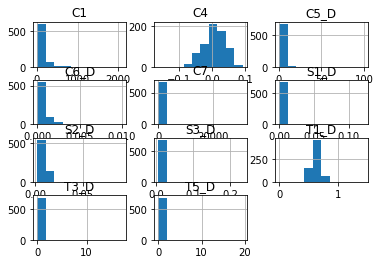

In [61]:
hist = cf.hist()

In [62]:
df['I3'] = df.I3.astype('float')

In [63]:
def assign_label(df_I3):
    if df_I3 > 100 and df_I3 < 4000:
        return 1
    elif df_I3 >= 4000 and df_I3 < 6000:
        return 2
    elif df_I3 >= 6000 and df_I3 < 10000:
        return 3
    else:
        return 4
      
df['I3'] = df['I3'].apply(assign_label)    
dummy_df = pd.get_dummies(df['I3'], prefix='Class')
df = pd.concat([df, dummy_df], axis=1)

df.head()

I1                                  I2  I3     C1     C2        C4  \
0  AATI  ADVANCED ANALOGIC TECHNOLOGIES INC   4  122.0   True  0.029074   
1  ABPI     ACCENTIA BIOPHARMACEUTICALS INC   4  259.0  False -0.013352   
2  ACAD          ACADIA PHARMACEUTICALS INC   4   90.0   True  0.020715   
3  ACHN       ACHILLION PHARMACEUTICALS INC   4  209.0   True  0.020023   
4  ACLI     AMERICAN COMMERCIAL LINES INC.    4   80.0   True -0.034895   

        C7   C3_D       C5_D      C6_D   ...         S1_D      S2_D      S3_D  \
0   51.345   True   3.864345  0.001111   ...     0.004875  0.009199  0.010929   
1   25.936  False  12.028832  0.000000   ...     0.003258  0.011105  0.010876   
2    7.378  False   3.369134  0.000000   ...     0.011593  0.006271  0.011403   
3    8.526  False   3.299697  0.000000   ...     0.009686  0.007144  0.013319   
4  632.298   True   3.726269  0.000500   ...     0.004518  0.010047  0.011261   

      Y1     Y2  Class_1  Class_2  Class_3  Class_4  Class_4  
0  False   True        1        0        0        0        1  
1   True  False        1        0        0        0        1  
2   True  False        1        0        0        0        1  
3   True   True        1        0        0        0        1  
4  False   True        0        1        0        0        1  

[5 rows x 23 columns]

In [64]:
df['I3'] = df.I3.astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 23 columns):
I1         682 non-null object
I2         682 non-null object
I3         682 non-null object
C1         682 non-null float64
C2         682 non-null bool
C4         682 non-null float64
C7         682 non-null float64
C3_D       682 non-null bool
C5_D       682 non-null float64
C6_D       682 non-null float64
T1_D       682 non-null float64
T3_D       682 non-null float64
T5_D       682 non-null float64
S1_D       682 non-null float64
S2_D       682 non-null float64
S3_D       682 non-null float64
Y1         682 non-null bool
Y2         682 non-null bool
Class_1    682 non-null uint8
Class_2    682 non-null uint8
Class_3    682 non-null uint8
Class_4    682 non-null uint8
Class_4    682 non-null uint8
dtypes: bool(4), float64(11), object(3), uint8(5)
memory usage: 80.7+ KB
